In [1]:
import numpy             as np
import matplotlib.pyplot as plt

from matplotlib          import rcParams, rc
# Change the matplotlib default parameters
# rcParams.update({'font.size':   12})
rcParams.update({'figure.dpi': 200})
# rc('font', family='serif')
# rc('text', usetex=True)

from astropy import units as units

from src.ode.acodes     import ODE
from src.rates          import initialise_abs, calculate_rates
from src.input          import setinput, getcst

from scipy.integrate    import solve_ivp
from astropy            import constants

### Physical constants

In [40]:
## constants
kB, mH, rGr, nGr, stckH, AUV_AV = getcst()

## input values physics
ρ, T, δ, Av, chemtype = setinput()

## input chemistry
chemtype = 'C'

## calculate H accretion on dust
Haccr = stckH *np.pi*(rGr**2.0)*ρ*nGr*(8.0*kB*T/(np.pi*mH))**0.5

yr_to_sec = units.year.to('s')         ## year in seconds

In [38]:
'''
TODO 
om te vermijden dat er kei veel moet geloopt worden over elke lijst van elke input parameter, 
kan er gesplit worden gewoon op spatie, en dan een ander keyword meegeven om te beslissen of alle
params gecombineerd worden, of dat het per model is.

'''



infile = '/lhome/silkem/ChemTorch/ChemTorch/input/input.txt'

filelines = list()

with open(infile, 'r') as f:
    lines = f.readlines()
    

print(lines)


for i in range(len(lines)):
    lines[i]=lines[i].replace(' \n', '')
    lines[i]=lines[i].replace('\n', '')
    lines[i]=lines[i].split(' ')

    if lines[i][0] == 'dens':
        dens_idx = i
        dens_line = lines[i][2:]

    if lines[i][0] == 'temp':
        temp_idx = i
        temp_line = lines[i][2:]

    if lines[i][0] == 'delta':
        delta_idx = i
        delta_line = lines[i][2:]

    if lines[i][0] == 'Av':
        Av_idx = i
        Av_line = lines[i][2:]


print(dens_line)
print(temp_line)

if len(dens_line) > 1 and dens_line[1] == ':':
    type = 'single'

if len(dens_line) > 1 and dens_line[1] == ';':
    type = 'combine'

else: type = 'none'

print(type)

input = dict()

['### Inputfile TorchChem ###\n', '### ------------------- ###\n', '\n', '## Use : to split input to create specific models.\n', '## Use ; to cross all input values.\n', '\n', '\n', '## --\n', '\n', '# density [Msol/yr]\n', 'dens = 1e-6 ; 1e-5\n', '\n', '# temperature [K]\n', 'temp = 2000\n', '\n', '# overall dilution of the radiation field\n', 'delta = 1\n', '\n', '# species-specific extinction (connected to optical depth)\n', 'Av = 1\n', '\n', '## --']
['1e-6', ';', '1e-5']
['2000']
combine


### Three body reactions

In [3]:
def read_rate_file():

    loc = 'rates/rate16_IP_2330K_AP_6000K.rates'

    rates = dict()
    with open(loc, 'r') as f:
        lines = f.readlines()
        for i in range(len(lines)):
            line = lines[i].split(':')
            rates[int(line[0])] = line[1:]
    
    type = list()
    no = list()
    α = np.zeros(len(rates))
    β = np.zeros(len(rates))
    γ = np.zeros(len(rates))
    for nb in rates:
        no.append(nb)
        type.append(str(rates[nb][0]))
        α[nb-1] = float(rates[nb][8])
        β[nb-1] = float(rates[nb][9])
        γ[nb-1] = float(rates[nb][10])

    return rates, no, type, α, β, γ

In [1]:
# Read the rates file and return the rate coefficients per reaction: 
#               reaction no.:type:R1:R2:P1:P2:P3:P4:NE:α : β : γ: Tl :Tu:ST:ACC:REF
# indices                 0    1  2  3  4  5  6  7  8  9  10  11  12  13 14 15 

In [63]:
rates, no, type, α, β, γ = read_rate_file()

In [4]:
def read_specs_file(chemtype):

    loc = 'rates/rate16_IP_6000K_'+chemtype+'rich_mean_Htot.specs'

    # specs = dict()

    specs = np.loadtxt(loc, skiprows=1,   max_rows=466, usecols=(1), dtype=str)
    consv = np.loadtxt(loc, skiprows=468, max_rows=2  , usecols=(1), dtype=str)
    parnt = np.loadtxt(loc, skiprows=471   , usecols= (0,1), dtype=str)
    

    return specs, (parnt).T, consv

specs, parnt, consv = read_specs_file('C')

### CO self-shielding (Visser et al. 2009)

In [3]:
from pathlib import Path


def shield_rewrite(loc):
    print(loc)

    ## Read file
    with open(loc, 'r') as f:
        lines = f.readlines()
    for i in range(len(lines)):                 ## remove '\n'
        lines[i]=lines[i].replace('\n', '')


    ## Retrieve values for N(H2) and N(CO)
    idx_H2 = lines.index('N(H2)')
    idx_CO = lines.index('N(12CO)')
    idx_sh = lines.index('12C16O')
    CO = list()
    for i in range(idx_CO+1, idx_H2):
        CO.append(lines[i])
    H2 = list()
    for i in range(idx_H2+1, idx_sh):
        H2.append(lines[i])

    ## get shielding rates in convenient format
    shield = list()
    row = ''
    for i in range(idx_sh+1, len(lines)-1):
        # print(i,len(lines))
        if i == len(lines)-2:
            # print('last')
            row = row + lines[i] + lines[i+1]
            shield.append(row)
            row = ''
        elif len(lines[i]) >= len(lines[i+1]):
            row = row + lines[i]
        else:
            row = row + lines[i]
            shield.append(row)
            row = ''

    ## write out again in convenient form
    with open(loc, 'w') as f:
        for i in range(idx_CO):
            f.write(lines[i]+'\n')
        f.write('\n')
        f.write('CO shielding rates     (for parameters/values rows & columns: check legend file)\n')
        for row in shield:
            f.write(row+'\n')

    legend = './shielding/CO/legend.txt'
    with open(legend, 'w') as f:
        f.write('Legend of CO shielding tables\n')
        f.write('\n')
        f.write('N(CO) - rows       N(H2) - columns\n')
        for i in range(len(H2)):
            f.write(CO[i]+'     '+H2[i]+'\n')
        for i in range(len(H2), len(CO)):
            f.write(CO[i]+'\n')

    return
 


In [9]:
dir_shielding = './shielding/CO/'

import os

locs = os.listdir(dir_shielding)

# for loc in locs:
#     shield_rewrite(loc)
    

In [4]:
def read_shielding(loc):
    shielding = np.loadtxt(loc, skiprows=9, dtype=np.float64)
    leg = './shielding/CO/legend.txt'

    CO = np.loadtxt(leg, skiprows = 3, dtype = np.float64, usecols = (0))
    H2 = np.loadtxt(leg, skiprows = 3, dtype = np.float64, usecols = (1), max_rows=shielding.shape[0])

    return shielding, CO, H2

## retrieve shielding rate, given N_CO & N_H2

def retrieve_rate(N_CO, N_H2, shielding, CO, H2):
    idx, = np.where(CO ==  N_CO)
    idx_CO = idx[0]
    idx, = np.where(H2 ==  N_H2)
    idx_H2 = idx[0]
    
    shieldrate = shielding[idx_H2, idx_CO]

    return shieldrate

def get_closest(target, input):
    return

In [10]:
loc = 'shield.03.5.35-557-36.dat'

shielding, CO, H2 = read_shielding(dir_shielding+loc)
rate = retrieve_rate(1,1e16,shielding, CO, H2)
print(rate)

0.8899


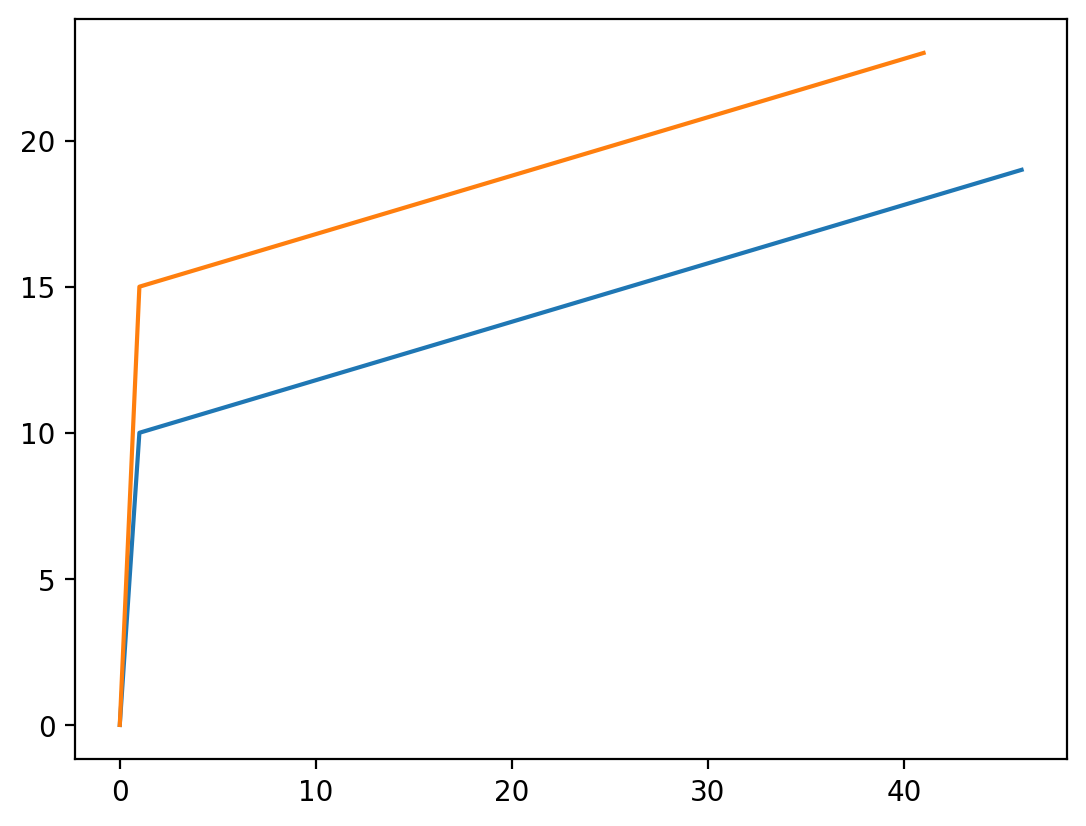

In [17]:
plt.plot(np.log10(CO))
plt.plot(np.log10(H2))


### Outflow density

In [51]:
def density(Mdot,v, r):
    '''
    Input 
        - mass-loss rate (Mdot) in units of Msol/yr
        - outflow velocity (v) in units of km/s
        - radius (r): location of the outflow, inputs of cm
    Output
        - density in units of g/cm^3
    '''
    # r    = 1e18 #* unt.cgs.cm                       # cm
    Mdot = Mdot * Msunyr                            # gram/s
    v    = v    * cms                               # cm/s


    dens = Mdot / (4*pi * v * r**2 * mu * mH)       # g/cm^3

    # dens = dens * g_to_kg * cm_to_m**(-3)           # kg/m^3

    return dens

In [52]:
r = 1.e15
print('{:.2E}'.format(density(1.e-5, 10., r)))
print('{:.2E}'.format(density(1.e-6, 15., r)))
print('{:.2E}'.format(density(1.e-7, 10., r)))
print('{:.2E}'.format(density(1.e-8, 5. , r)))

1.13E+07
7.51E+05
1.13E+05
2.25E+04
